In [33]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [34]:
train_path = "../modified_data/v02_train.csv"
test_path = "../modified_data/v02_test.csv"

In [42]:
train = pd.read_csv(train_path, index_col=0)
test = pd.read_csv(test_path,index_col=0)

In [43]:
train["is_test"] = 0
test["is_test"] = 1
concat = pd.concat([train, test])

In [44]:
pd.set_option('display.max_columns', None)

In [45]:
concat.head()

,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,등기신청일자,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-등록일자,k-수정일자,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test
0,개포6차우성,79.97,201712,8,3,1987,,-,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0
1,개포6차우성,79.97,201712,22,4,1987,,-,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,0
2,개포6차우성,54.98,201712,28,5,1987,,-,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,0
3,개포6차우성,79.97,201801,3,4,1987,,-,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,0
4,개포6차우성,79.97,201801,8,2,1987,,-,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,0


In [49]:
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['사용허가여부'] = concat['사용허가여부'].replace({'Y': 1, 'N': 0})
concat['관리비 업로드'] = concat['관리비 업로드'].replace({'N': 0, 'Y': 1})

In [50]:
concat.head(10)

,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,등기신청일자,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-등록일자,k-수정일자,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test
0,개포6차우성,79.97,201712,8,3,1987,NaN,NaN,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0
1,개포6차우성,79.97,201712,22,4,1987,NaN,NaN,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,0
2,개포6차우성,54.98,201712,28,5,1987,NaN,NaN,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,0
3,개포6차우성,79.97,201801,3,4,1987,NaN,NaN,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,0
4,개포6차우성,79.97,201801,8,2,1987,NaN,NaN,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,0
5,개포6차우성,79.97,201801,11,1,1987,NaN,NaN,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,0
6,개포6차우성,79.97,201803,19,2,1987,NaN,NaN,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,139500.0,0
7,개포6차우성,54.98,201804,5,5,1987,NaN,NaN,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,107500.0,0
8,개포6차우성,79.97,201806,28,3,1987,NaN,NaN,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,145000.0,0
9,개포6차우성,54.98,201807,9,3,1987,NaN,NaN,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,112000.0,0


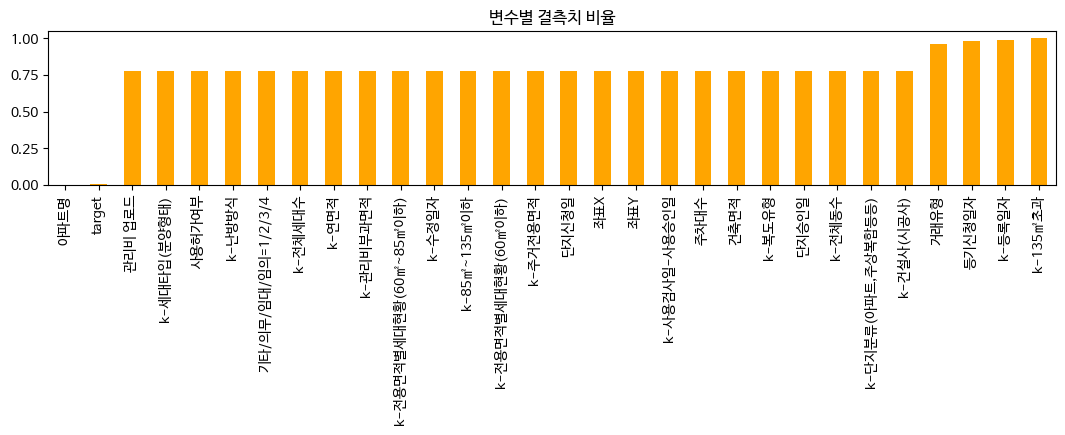

In [51]:
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

# 결측치 해석
1. k-135m2 초과는 수량을 의미하므로 0으로 만듦

In [52]:

concat['k-135㎡초과'] = concat['k-135㎡초과'].replace(np.nan, 0)
concat['k-85㎡~135㎡이하'] =concat['k-85㎡~135㎡이하'].replace(np.nan, 0)
concat['k-전용면적별세대현황(60㎡~85㎡이하)'] =concat['k-전용면적별세대현황(60㎡~85㎡이하)'].replace(np.nan, 0)
concat['k-전용면적별세대현황(60㎡이하)'] = concat['k-전용면적별세대현황(60㎡이하)'].replace(np.nan, 0)

In [53]:
concat.head(2)

,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,등기신청일자,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-등록일자,k-수정일자,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test
0,개포6차우성,79.97,201712,8,3,1987,NaN,NaN,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0
1,개포6차우성,79.97,201712,22,4,1987,NaN,NaN,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,0


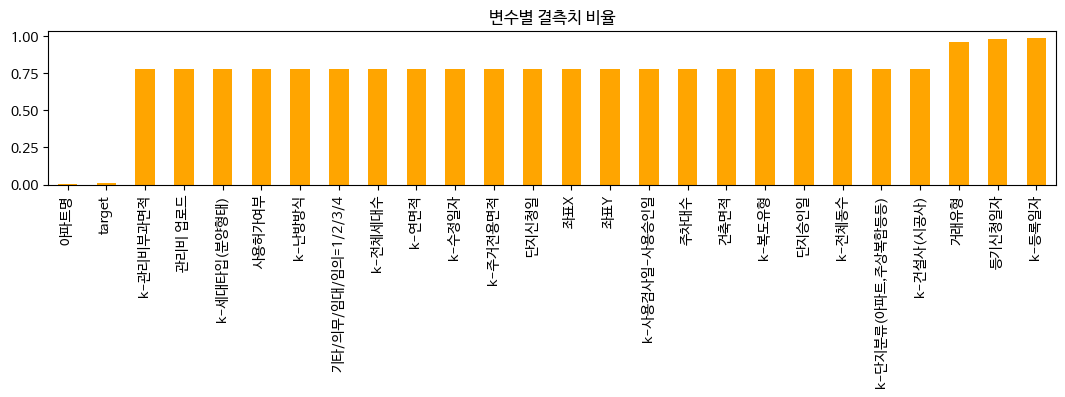

In [54]:
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [55]:
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]
concat_select.head(10)

,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-수정일자,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test
0,개포6차우성,79.97,201712,8,3,1987,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0
1,개포6차우성,79.97,201712,22,4,1987,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,0
2,개포6차우성,54.98,201712,28,5,1987,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,0
3,개포6차우성,79.97,201801,3,4,1987,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,0
4,개포6차우성,79.97,201801,8,2,1987,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,0
5,개포6차우성,79.97,201801,11,1,1987,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,0
6,개포6차우성,79.97,201803,19,2,1987,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,139500.0,0
7,개포6차우성,54.98,201804,5,5,1987,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,107500.0,0
8,개포6차우성,79.97,201806,28,3,1987,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,145000.0,0
9,개포6차우성,54.98,201807,9,3,1987,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,112000.0,0


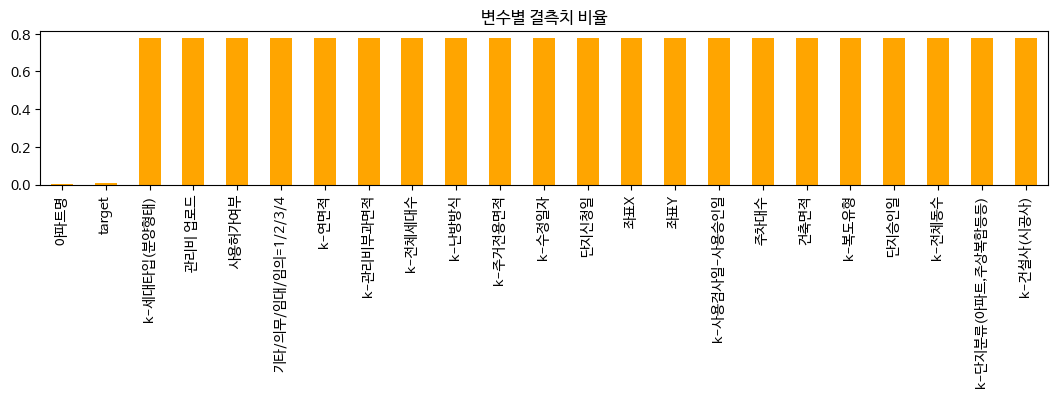

In [56]:
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 33 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   아파트명                    1125958 non-null  object 
 1   전용면적(㎡)                 1128094 non-null  float64
 2   계약년월                    1128094 non-null  int64  
 3   계약일                     1128094 non-null  int64  
 4   층                       1128094 non-null  int64  
 5   건축년도                    1128094 non-null  int64  
 6   k-단지분류(아파트,주상복합등등)      250821 non-null   object 
 7   k-세대타입(분양형태)            251969 non-null   object 
 8   k-복도유형                  251640 non-null   object 
 9   k-난방방식                  251969 non-null   object 
 10  k-전체동수                  250887 non-null   float64
 11  k-전체세대수                 251969 non-null   float64
 12  k-건설사(시공사)              250457 non-null   object 
 13  k-사용검사일-사용승인일           251835 non-null   object 
 14  k-연면적

In [60]:
pd.set_option('display.max_rows', None)

In [68]:
concat_select.head()

,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-수정일자,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test
0,개포6차우성,79.97,201712,8,3,1987,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0
1,개포6차우성,79.97,201712,22,4,1987,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,0
2,개포6차우성,54.98,201712,28,5,1987,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,0
3,개포6차우성,79.97,201801,3,4,1987,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,0
4,개포6차우성,79.97,201801,8,2,1987,아파트,분양,계단식,개별난방,8.0,270.0,우성건설,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,2023-09-23 17:21:41.0,4858.0,262.0,임의,2022-11-17 13:00:29.0,1.0,0.0,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,0


In [69]:
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['아파트명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-사용검사일-사용승인일', 'k-수정일자', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '단지신청일']
